# Gradient example: $\nabla_{M_{vir}^{NFW}}$ (time_integration)

In [1]:
import os
from math import pi
from time import time



# os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"  # Use only the first GPU
from autocvd import autocvd
autocvd(num_gpus = 1)

# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c


# from ott.tools.unreg import wassdis_p


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, NFW_POTENTIAL, PlummerParams, MN_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle
from odisseo.utils import E_tot, Angular_momentum
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e4 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [ ]:
# Define the 
config = SimulationConfig(N_particles=1_00, 
                          return_snapshots=False, 
                          num_snapshots=100, 
                          num_timesteps=200, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme= DIRECT_ACC_MATRIX,
                        #   double_map=True,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (5* u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=False, num_snapshots=100, fixed_timestep=True, num_timesteps=200, softening=np.float64(0.010000000000000002), integrator=0, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(0,), differentation_mode=1, num_checkpoints=100)
SimulationParams(G=1, t_end=np.float64(0.03353543704601728), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(10000.0)), NFW_params=NFWParams(Mvir=np.float64(100000000.0), r_s=np.float64(2.0), c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(alpha=-1.8, r_c=1.9))


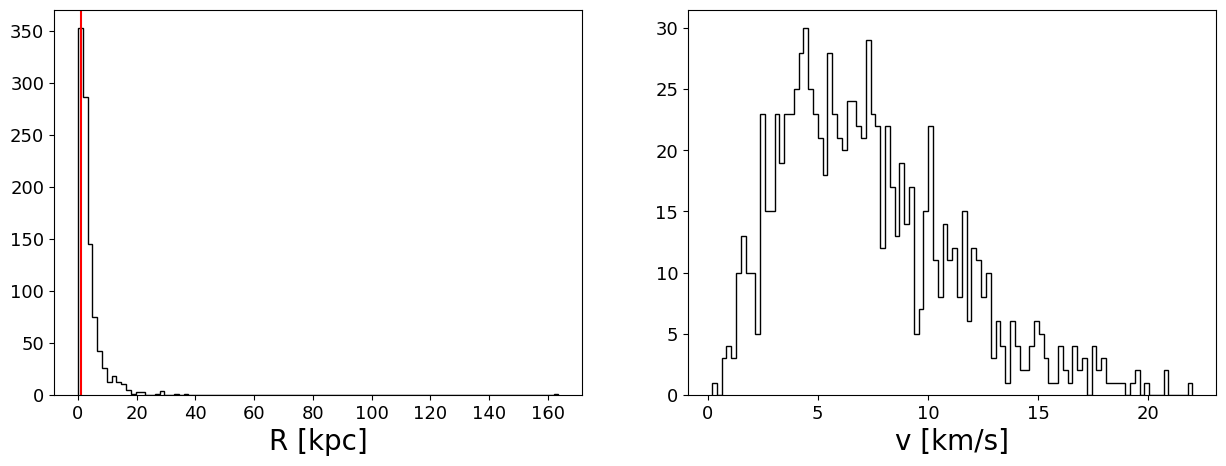

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [5]:
@jit
def mass_enclosed_NFW(R, params):
    """
    Compute the mass of the NFW potential at a given radius R.

    ref: wikipedia
    """
    c = params.NFW_params.c
    Mvir = params.NFW_params.Mvir
    r_s = params.NFW_params.r_s
    rho_0 = (Mvir / (4*jnp.pi * r_s**3)) * (jnp.log(1+c) - c/(1+c))**-1

    return 4*jnp.pi*rho_0*r_s**3 * (jnp.log(1 + R/r_s) - R/(r_s + R))



In [6]:
# radial distance of the center of mass
rp=200*u.kpc.to(code_units.code_length)

#sampling the center of mass on the sphere
key = random.PRNGKey(42)
num_samples = 1  # Number of positions to generate
pos = sample_position_on_circle(key, rp, num_samples)
vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
state_com = construct_initial_state(pos, vel)

e = jnp.array(0.4)
inclination = jnp.radians(30)  # 30-degree inclination
mass1 = mass_enclosed_NFW(rp, params)
mass2 = params.Plummer_params.Mtot 
_, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                mass2=mass2,
                                rp=rp,
                                e=e,
                                params=params)
bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
vel = inclined_circular_velocity(pos, bulk_velocity_modulus, inclination)


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos
velocities = velocities + vel
initial_state = construct_initial_state(positions, velocities)


#evolve 
target_state = time_integration(initial_state, mass, config, params)
distribution_r_target = jnp.linalg.norm(target_state[:, 0], axis=1)
hist_target, _ = jnp.histogram(distribution_r_target, bins=100, range=(0, (25*u.kpc).to(code_units.code_length).value))
Lz_target = Angular_momentum(target_state, mass, )[:, 2]
Lx_target = Angular_momentum(target_state, mass, )[:, 0]
Ly_target = Angular_momentum(target_state, mass, )[:, 1]

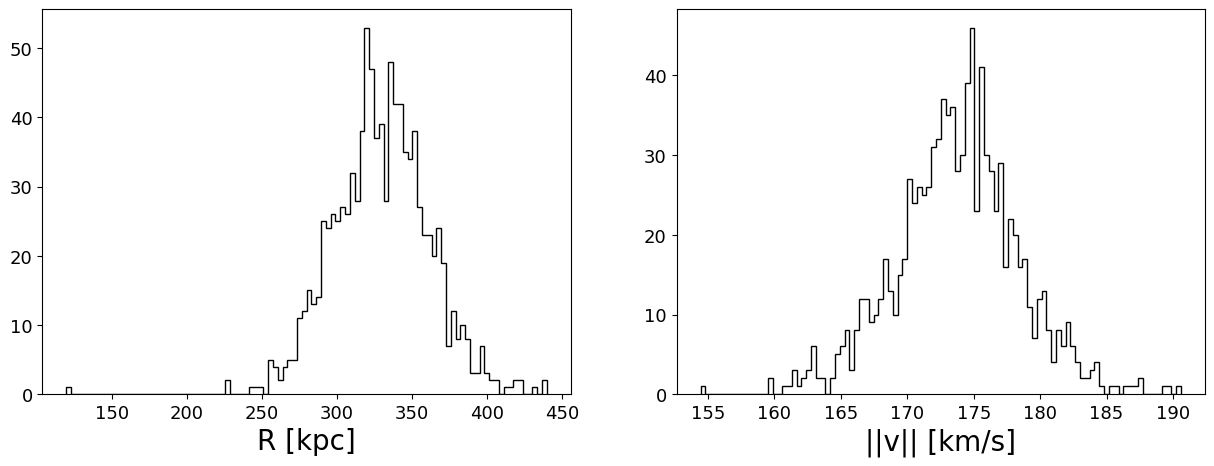

In [7]:
#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((distribution_r_target * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('||v|| [km/s]')
plt.show()

Text(0.5, 0.92, 'Target state')

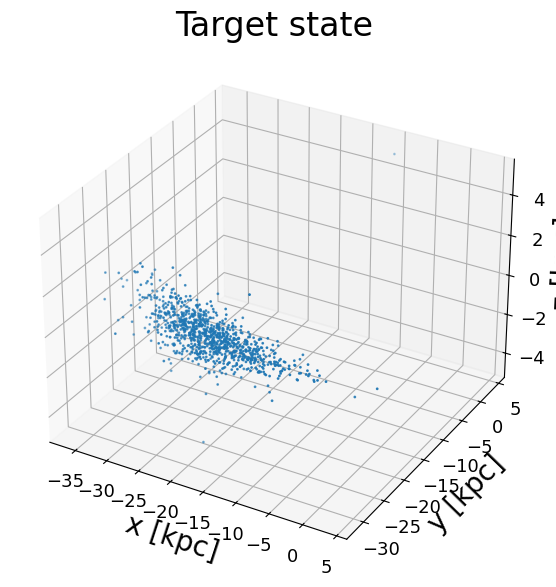

In [8]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(target_state[:, 0, 0], target_state[:, 0, 1], target_state[:, 0, 2], s=1)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_zlabel('z [kpc]')
# ax.set_xlim(-rp, rp)
# ax.set_ylim(-rp, rp)
# ax.set_zlim(-rp, rp)

ax.set_title('Target state')

(array([  1.,   0.,   0.,   4.,  49., 227., 402., 250.,  58.,   9.]),
 array([11.96609097, 15.16636789, 18.3666448 , 21.56692171, 24.76719863,
        27.96747554, 31.16775245, 34.36802937, 37.56830628, 40.76858319,
        43.96886011]),
 <BarContainer object of 10 artists>)

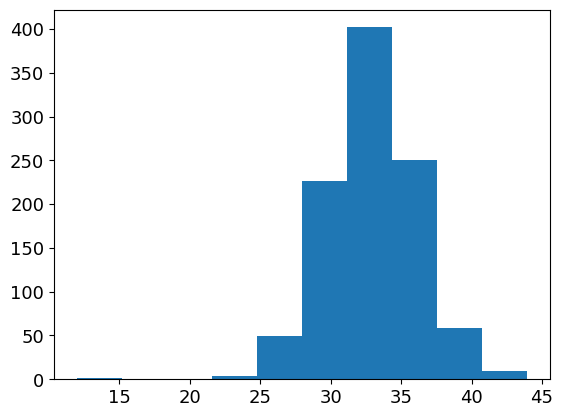

In [9]:
plt.hist(jnp.linalg.norm(target_state[:, 0], axis=1))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1., 146., 818.,  34.]),
 array([16.17164208, 20.55838223, 24.94512239, 29.33186254, 33.71860269,
        38.10534285, 42.492083  , 46.87882316, 51.26556331, 55.65230347,
        60.03904362]),
 <BarContainer object of 10 artists>)

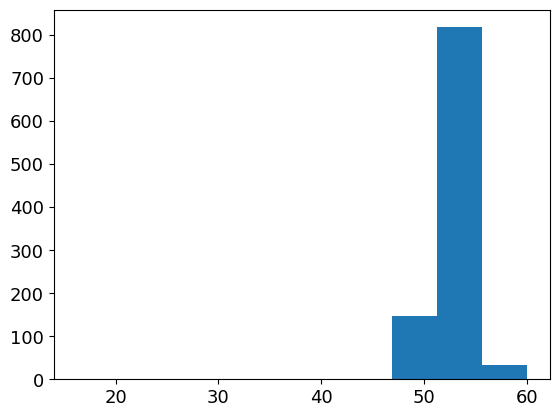

In [10]:
plt.hist(Lz_target)

In [11]:
def js_divergence(hist1, hist2, epsilon=1e-8):
    hist1 = jnp.clip(hist1, epsilon, 1.0)
    hist2 = jnp.clip(hist2, epsilon, 1.0)
    m = 0.5 * (hist1 + hist2)
    return 0.5 * jnp.sum(hist1 * jnp.log(hist1 / m)) + 0.5 * jnp.sum(hist2 * jnp.log(hist2 / m))

def kl_divergence(hist1, hist2, epsilon=1e-8):  
    hist1 = jnp.clip(hist1, epsilon, 1.0)
    hist2 = jnp.clip(hist2, epsilon, 1.0)
    return jnp.sum(hist1 * jnp.log(hist1 / hist2)) 

def chi_squared_distance(hist1, hist2, epsilon=1e-8):
    return jnp.sum((hist1 - hist2)**2 / (hist1 + hist2 + epsilon))

def wasserstein_distance(hist1, hist2, ):
    hist1_cum = jnp.cumsum(hist1)
    hist2_cum = jnp.cumsum(hist2)
    return jnp.sum(jnp.abs(hist1_cum - hist2_cum))
    
def time_integration_for_mass_grad(Mvir, t_end, e, inclination, key):
    key = random.PRNGKey(key)
    new_params = params._replace(
    NFW_params=params.NFW_params._replace(
        Mvir=Mvir 
    ))

    new_params = new_params._replace(
        t_end=t_end * u.Gyr.to(code_units.code_time),
    )

    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    pos = sample_position_on_circle(key, rp, num_samples)
    vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
    state_com = construct_initial_state(pos, vel)

   
    mass1 = mass_enclosed_NFW(rp, new_params)
    mass2 = new_params.Plummer_params.Mtot
    _, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                    mass2=mass2,
                                    rp=rp,
                                    e=e,
                                    params=new_params)
    bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
    vel = inclined_circular_velocity(pos, bulk_velocity_modulus, inclination)


    # Add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos
    velocities = velocities + vel
    initial_state = construct_initial_state(positions, velocities)
    
    #integrate in time
    final_state = time_integration(initial_state, mass, config, new_params)

    # Calculate the loss

    #THIS ONE WORKS THE BEST FOR NOW
    @jit
    def permutation_invariant_momentum_loss(final_state, target_state):
        """Loss based on statistical moments - invariant to particle ordering"""
        @jit 
        def skewness(data, mean, std):
            return jnp.mean((data-mean)**3) / (std**3)

        # Extract positions and velocities
        final_pos = final_state[:, 0]  # (N, 3)
        target_pos = target_state[:, 0]  # (N, 3)
        final_vel = final_state[:, 1]  # (N, 3)
        target_vel = target_state[:, 1]  # (N, 3)
        
        # Radial distances
        final_r = jnp.linalg.norm(final_pos, axis=1)
        target_r = jnp.linalg.norm(target_pos, axis=1)
        
        # Velocity magnitudes
        final_v = jnp.linalg.norm(final_vel, axis=1)
        target_v = jnp.linalg.norm(target_vel, axis=1)

        # Angular momentum components
        Lz_final = Angular_momentum(final_state, mass)[:, 2]  # Lz component
        Lx_final = Angular_momentum(final_state, mass)[:, 0]  # Lx component
        Ly_final = Angular_momentum(final_state, mass)[:, 1]  # Ly component
        
        # Statistical moments (all permutation-invariant)
        loss = 0.0
        
        # Position moments
        mean_final_r, mean_target_r = jnp.mean(final_r), jnp.mean(target_r)
        std_final_r, std_target_r = jnp.std(final_r), jnp.std(target_r)
        skewness_final_r, skewness_target_r = skewness(final_r, mean_final_r, std_final_r), skewness(target_r, mean_target_r, std_target_r)
        loss += (mean_final_r - mean_target_r)**2  # Mean radius
        loss += (std_final_r - std_target_r)**2    # Std radius
        loss += (skewness_final_r - skewness_target_r)**2  # Skewness radius
        
        # Velocity moments
        mean_v_final, mean_target_v = jnp.mean(final_v), jnp.mean(target_v)
        std_v_final, std_target_v = jnp.std(final_v), jnp.std(target_v)
        skewness_final_v, skewness_target_v = skewness(final_v, mean_v_final, std_v_final), skewness(target_v, mean_target_v, std_target_v)
        loss += (mean_v_final - mean_target_v)**2  # Mean velocity
        loss += (std_v_final - std_target_v)**2    # Std velocity
        loss += (skewness_final_v - skewness_target_v)**2  # Skewness velocity

        # L_z Angular momentum moments
        mean_Lz_final, mean_Lz_target = jnp.mean(Lz_final), jnp.mean(Lz_target)
        std_Lz_final, std_Lz_target = jnp.std(Lz_final), jnp.std(Lz_target)
        skewness_final_Lz, skewness_target_Lz = skewness(Lz_final, mean_Lz_final, std_Lz_final), skewness(Lz_target, mean_Lz_target, std_Lz_target)
        loss += (mean_Lz_final - mean_Lz_target)**2  # Mean Lz
        loss += (std_Lz_final - std_Lz_target)**2    # Std Lz
        loss += (skewness_final_Lz - skewness_target_Lz)**2

        # Add more moments as needed, e.g., Lx, Ly, etc.
        mean_Lx_final, mean_Lx_target = jnp.mean(Lx_final), jnp.mean(Lx_target)
        std_Lx_final, std_Lx_target = jnp.std(Lx_final), jnp.std(Lx_target)
        skewness_final_Lx, skewness_target_Lx = skewness(Lx_final, mean_Lx_final, std_Lx_final), skewness(Lx_target, mean_Lx_target, std_Lx_target)
        loss += (mean_Lx_final - mean_Lx_target)**2
        loss += (std_Lx_final - std_Lx_target)**2
        loss += (skewness_final_Lx - skewness_target_Lx)**2

        mean_Ly_final, mean_Ly_target = jnp.mean(Ly_final), jnp.mean(Ly_target)
        std_Ly_final, std_Ly_target = jnp.std(Ly_final), jnp.mean(Ly_target)
        skewness_final_Ly, skewness_target_Ly = skewness(Ly_final, mean_Ly_final, std_Ly_final), skewness(Ly_target, mean_Ly_target, std_Ly_target)
        loss += (mean_Ly_final - mean_Ly_target)**2
        loss += (std_Ly_final - std_Ly_target)**2
        loss += (skewness_final_Ly - skewness_target_Ly)**2

        
        return loss
    
    @jit
    def permutation_invariant_loss(final_state, target_state):
        range = (0, 200)
        bins = 300
        min_r_target, max_r_target = jnp.min(distribution_r_target), jnp.max(distribution_r_target)
        hist_target_r, _ = jnp.histogram(distribution_r_target, bins=bins,)
        hist_target_r = hist_target_r / jnp.sum(hist_target_r)  # Normalize
        distribution_r_final = jnp.linalg.norm(final_state[:, 0], axis=1)
        kde_r = jax.scipy.stats.gaussian_kde(distribution_r_final)
        r_lim = jnp.linspace(min_r_target, max_r_target, bins)
        m_r = jnp.meshgrid(r_lim, indexing='ij')
        counts_r = kde_r.evaluate(jnp.array([m_r[0].reshape(-1)])).reshape(-1)
        counts_r = counts_r/jnp.sum(counts_r)
        # loss = jnp.sum((counts_r - hist_target_r)**2)
        # loss = kl_divergence(counts_r, hist_target_r)
        loss = wasserstein_distance(counts_r, hist_target_r)

        distribution_v_target = jnp.linalg.norm(target_state[:, 1]*code_units.code_velocity.to(u.km/u.s), axis=1)
        min_v_target, max_v_target = jnp.min(distribution_v_target), jnp.max(distribution_v_target)
        hist_target_v, _ = jnp.histogram(distribution_v_target, bins=bins)
        hist_target_v = hist_target_v / jnp.sum(hist_target_v)  # Normalize
        distribution_v_final = jnp.linalg.norm(final_state[:, 1]*code_units.code_velocity.to(u.km/u.s), axis=1)
        kde_v = jax.scipy.stats.gaussian_kde(distribution_v_final)
        v_lim = jnp.linspace(min_v_target, max_v_target, bins)
        m_v = jnp.meshgrid(v_lim, indexing='ij')
        counts_v = kde_v.evaluate(jnp.array([m_v[0].reshape(-1)])).reshape(-1)
        # counts_v = counts_v/jnp.sum(counts_v)
        # loss += jnp.sum((counts_v - hist_target_v)**2)
        # loss += kl_divergence(counts_v, hist_target_v)
        loss += wasserstein_distance(counts_v, hist_target_v)


        min_Lz_target, max_Lz_target = jnp.min(Lz_target), jnp.max(Lz_target)
        hist_target_Lz, _ = jnp.histogram(Lz_target, bins=bins)
        hist_target_Lz = hist_target_Lz / jnp.sum(hist_target_Lz)
        Lz_final = Angular_momentum(final_state, mass)[:, 2]
        kde_Lz = jax.scipy.stats.gaussian_kde(Lz_final)
        Lz_lim = jnp.linspace(min_Lz_target, max_Lz_target, bins)
        m_Lz = jnp.meshgrid(Lz_lim, indexing='ij')
        counts_Lz = kde_Lz.evaluate(jnp.array([m_Lz[0].reshape(-1)])).reshape(-1)
        counts_Lz /= jnp.sum(counts_Lz)
        # loss += jnp.sum((counts_Lz - hist_target_Lz)**2)
        # loss += kl_divergence(counts_Lz, hist_target_Lz)
        loss += wasserstein_distance(counts_Lz, hist_target_Lz)

        # hist_target_Lx = jnp.histogram(Lx_target, range=range, bins=bins)[0]
        # hist_target_Lx = hist_target_Lx / jnp.sum(hist_target_Lx)
        # Lx_final = Angular_momentum(final_state, mass)[:, 0]
        # kde_Lx = jax.scipy.stats.gaussian_kde(Lx_final)
        # Lx_lim = jnp.linspace(range[0], range[1], bins)
        # m_Lx = jnp.meshgrid(Lx_lim, indexing='ij')
        # counts_Lx = kde_Lx.evaluate(jnp.array([m_Lx[0].reshape(-1)])).reshape(-1)
        # counts_Lx /= jnp.sum(counts_Lx)
        # # loss = jnp.sum((counts_Lx - hist_target_Lx)**2)
        # loss += kl_divergence(counts_Lx, hist_target_Lx)

        # hist_target_Ly = jnp.histogram(Ly_target, range=range, bins=bins)[0]
        # hist_target_Ly = hist_target_Ly / jnp.sum(hist_target_Ly)
        # Ly_final = Angular_momentum(final_state, mass)[:, 1]
        # kde_Ly = jax.scipy.stats.gaussian_kde(Ly_final)
        # Ly_lim = jnp.linspace(range[0], range[1], bins)
        # m_Ly = jnp.meshgrid(Ly_lim, indexing='ij')
        # counts_Ly = kde_Ly.evaluate(jnp.array([m_Ly[0].reshape(-1)])).reshape(-1)
        # counts_Ly /= jnp.sum(counts_Ly)
        # # loss = jnp.sum((counts_Ly - hist_target_Ly)**2)
        # loss += kl_divergence(counts_Ly, hist_target_Ly)

        # hist_2d_target, _, _ = jnp.histogram2d(distribution_r_target,
        #                                  Lz_target,
        #                                  bins=bins, range=(range, range))
        # hist_2d_target = hist_2d_target / jnp.sum(hist_2d_target)  # Normalize

        # distribution_r_final = jnp.linalg.norm(final_state[:, 0], axis=1)
        # Lz_final = Angular_momentum(final_state, mass)[:, 2]
        # kde_2d = jax.scipy.stats.gaussian_kde(jnp.vstack((distribution_r_final, Lz_final)))
        # r_lim = jnp.linspace(range[0], range[1], bins)
        # Lz_lim = jnp.linspace(range[0], range[1], bins)
        # m_r, m_Lz = jnp.meshgrid(r_lim, Lz_lim, indexing='ij')
        # counts_2d = kde_2d.evaluate(jnp.array([m_r.reshape(-1), m_Lz.reshape(-1)])).reshape((bins, bins))
        # counts_2d /= jnp.sum(counts_2d)  # Normalize
        # # loss = jnp.sum((counts_2d - hist_2d_target)**2)
        # loss = kl_divergence(counts_2d, hist_2d_target)

        # distribution_v_target = jnp.linalg.norm(target_state[:, 1], axis=1)*code_units.code_velocity.to(u.km/u.s)
        # hist_2d_target, _, _ = jnp.histogram2d(distribution_r_target, distribution_v_target, 
        #                                         bins=bins, range=(range, range))
        # hist_2d_target = hist_2d_target / jnp.sum(hist_2d_target)
        # distribution_r_final = jnp.linalg.norm(final_state[:, 0], axis=1)
        # distribution_v_final = jnp.linalg.norm(final_state[:, 1], axis=1)*code_units.code_velocity.to(u.km/u.s)
        # kde_2d = jax.scipy.stats.gaussian_kde(jnp.vstack((distribution_r_final, distribution_v_final)))
        # r_lim = jnp.linspace(range[0], range[1], bins)
        # v_lim = jnp.linspace(range[0], range[1], bins)
        # m_r, m_v = jnp.meshgrid(r_lim, v_lim, indexing='ij')
        # counts_2d = kde_2d.evaluate(jnp.array([m_r.reshape(-1), m_v.reshape(-1)])).reshape((bins, bins))
        # counts_2d /= jnp.sum(counts_2d)  # Normalize
        # loss = jnp.sum((counts_2d - hist_2d_target)**2)

        return loss

    # @jit
    # def cosine_distance(final_state, target_state):
    #     """Cosine distance between the final and target states."""
    #     final_pos = final_state[:, 0]
    #     target_pos = target_state[:, 0]
    #     final_vel = final_state[:, 1]
    #     target_vel = target_state[:, 1]

    #     r_target = jnp.sort(jnp.linalg.norm(target_pos, axis=1))
    #     r_final = jnp.sort(jnp.linalg.norm(final_pos, axis=1))
    #     v_target = jnp.sort(jnp.linalg.norm(target_vel, axis=1))
    #     v_final = jnp.sort(jnp.linalg.norm(final_vel, axis=1))
    #     # Calculate cosine similarity
    #     cos_sim_r = jnp.dot(r_final, r_target) / (jnp.linalg.norm(r_final) * jnp.linalg.norm(r_target))
    #     cos_sim_v = jnp.dot(v_final, v_target) / (jnp.linalg.norm(v_final) * jnp.linalg.norm(v_target))
    #     # Calculate cosine distance
    #     cos_dist_r = 1 - cos_sim_r
    #     cos_dist_v = 1 - cos_sim_v  

    #     return cos_dist_r + cos_dist_v

    
    loss = permutation_invariant_momentum_loss(final_state, target_state)
    # loss = permutation_invariant_loss(final_state, target_state)

    # loss = cosine_distance(final_state, target_state)

    
    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (0.5e12 * u.Msun).to(code_units.code_mass).value
e = 0.35
inclination = jnp.radians(25)  # 25-degree inclination
t_end = 4.5 * u.Gyr.to(code_units.code_time)
key = 0
loss, grad = jax.value_and_grad(time_integration_for_mass_grad, argnums=[0, 1, 2, 3])(Mvir, t_end, e, inclination, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 (Array(0.00797785, dtype=float64), Array(-8065.44585529, dtype=float64, weak_type=True), Array(295519.2875245, dtype=float64, weak_type=True), Array(1526.78514749, dtype=float64, weak_type=True))
Loss:
 256073.3557724594


In [ ]:
n_sim = 5
M_tot_values = (jnp.linspace(0.5e12, 1.5e12, n_sim)*u.Msun).to(code_units.code_mass).value  # Adjust range based on expected values
t_end_values = (jnp.linspace(3, 7, n_sim)*u.Gyr).to(code_units.code_time).value     # Adjust range based on expected timescales
e_values = (jnp.linspace(0.1, 0.6, 6))  # Eccentricity values
inclination_values = (jnp.radians(jnp.linspace(0, 60, 6)))  # Inclination angles in radians
keys = 30**4


# Create a meshgrid
M_tot_grid, t_end_grid, e_grid, inclination_grid = jnp.meshgrid(M_tot_values, t_end_values, e_values, inclination_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()
e_flat = e_grid.flatten()
inclination_flat = inclination_grid.flatten()
keys_flat = jnp.arange(len(Mvir_flat))  # Create a flat array of keys

loss, grad = jax.vmap(jax.value_and_grad(time_integration_for_mass_grad, argnums=[0, 1, ]), )(Mvir_flat, t_end_flat, e_flat, inclination_flat, keys_flat)

loss = loss.reshape(M_tot_grid.shape)

# loss, grad = vmap(jax.value_and_grad(time_integration_for_mass_grad))(Mvir, keys)

# plt.figure()
# plt.plot((Mvir*code_units.code_mass).to(u.Msun), loss)
# plt.axvline((1e12 * u.Msun).value, color='r', label='True $M_{tot}$')
# plt.xlabel("$M_{vir}$ [$M_\odot$]")
# plt.yscale('log')
# # plt.xscale('log')
# plt.ylabel('Loss')
# plt.legend()


2025-06-03 17:51:01.805588: E external/xla/xla/service/gpu/gpu_hlo_schedule.cc:654] The byte size of input/output arguments (180086915936) exceeds the base limit (31713951744). This indicates an error in the calculation!
2025-06-03 17:51:01.868068: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 0B (0 bytes) by rematerialization; only reduced to 213.54GiB (229286115172 bytes), down from 213.60GiB (229350915556 bytes) originally
2025-06-03 17:51:14.892263: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB (rounded to 4320000000)requested by op 
2025-06-03 17:51:14.892487: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ************************************************************************************************____
E0603 17:51:14.892516 3944597 pjrt_stream_executor_client.cc:2917] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory whi

In [ ]:
loss.shape

(5, 5, 6, 6)

In [ ]:
loss[:, :, 0, 0].shape

(5, 5)

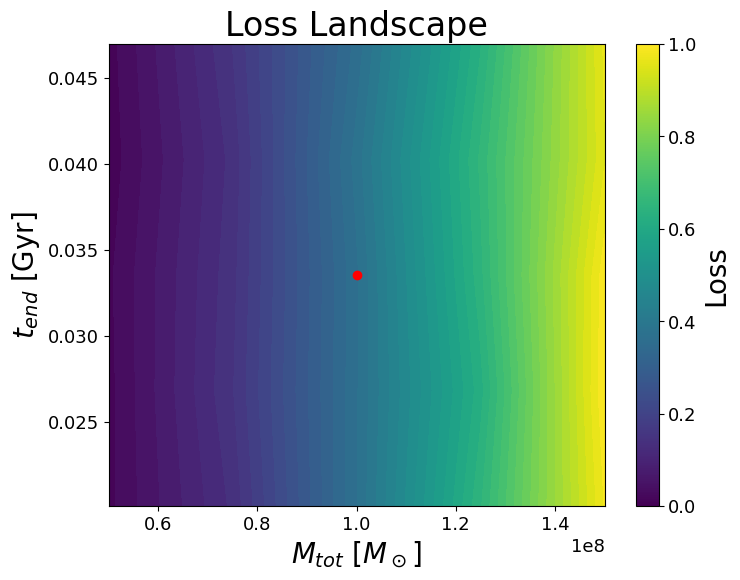

In [ ]:

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(M_tot_values, t_end_values, loss[:, :, 2, 2].T, levels=50, cmap="viridis")
plt.scatter((1e12 * u.Msun).to(code_units.code_mass).value, (5 * u.Gyr).to(code_units.code_time).value, color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$M_{tot}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("Loss Landscape")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (4, 900)

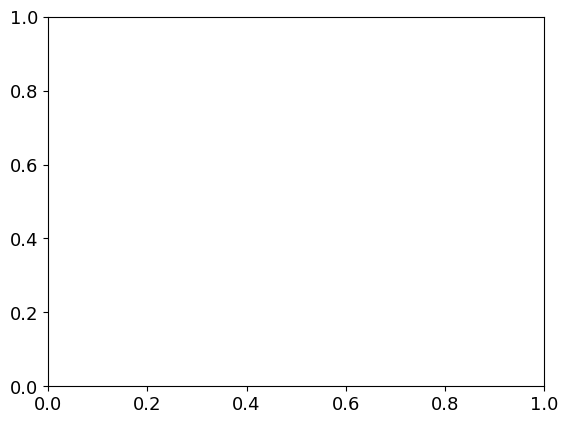

In [ ]:
plt.plot((Mvir*code_units.code_mass).to(u.Msun),grad)
plt.axvline((1e12 * u.Msun).value, color='r', label='True $M_{tot}$')
plt.axhline(0, color='k', linestyle='--', label='Zero gradient')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
# plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\nabla_{M^{NFW}_{vir}} L $')
plt.legend()